In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
img_size = 256
Batch_size = 32
channels = 3
EPOCHS = 10

In [5]:
df= tf.keras.preprocessing.image_dataset_from_directory("Brain tumour",shuffle=True,image_size=(256,256),batch_size=32)
df

Found 3000 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Unimportant trials

In [6]:
img= tf.data.Dataset.list_files("Brain tumour/*/*",shuffle=False)
len(img)

3000

In [7]:
for file in img.take(4):
    print(file.numpy())

b'Brain tumour\\no\\No12.jpg'
b'Brain tumour\\no\\No13.jpg'
b'Brain tumour\\no\\No14.jpg'
b'Brain tumour\\no\\No15.jpg'


In [8]:
class_names= df.class_names
class_names

['no', 'yes']

In [9]:
len(df)

94

In [10]:
for image_batch,label_batch in df.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1]


In [11]:
_

94

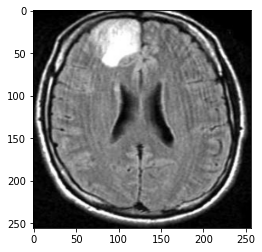

In [12]:
for image_batch,label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype('uint8'))

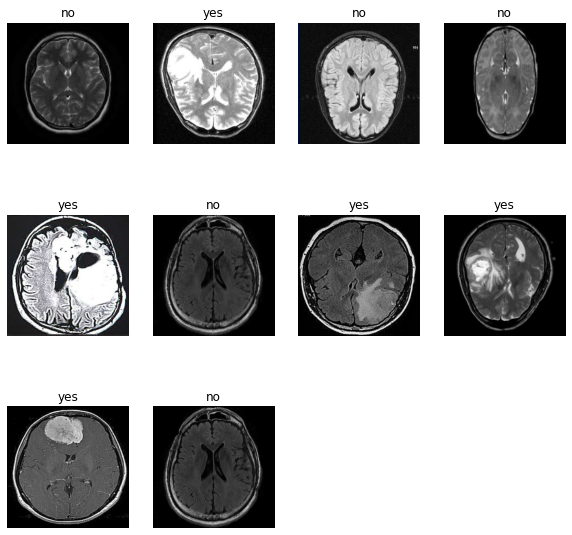

In [13]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in df.take(1):
    for i in range(10):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        

In [14]:
len(df)

94

# Train Test split

In [15]:
train_size=0.8
len(df)*train_size

75.2

In [16]:
train_ds = df.take(72)
len(train_ds)

72

In [17]:
rest_ds = df.skip(72)
len(rest_ds)

22

In [18]:
val_size = 0.1
len(df)*val_size

9.4

In [19]:
val_ds = rest_ds.take(9)
len(val_ds)

9

In [20]:
test_ds = rest_ds.skip(9)
len(test_ds)

13

In [21]:
def get_dataset_splits(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [22]:
train_ds, val_ds, test_ds = get_dataset_splits(df)

In [23]:
len(train_ds)

75

In [24]:
len(test_ds)

10

In [25]:
len(val_ds)

9

In [26]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augumentation

In [28]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model building

In [31]:
input_Shape = (Batch_size,img_size,img_size,channels)
n_classes = 3

model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,kernel_size = (3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu', input_shape= input_Shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_Shape)

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
75/75 [==============================] - 180s 2s/step - loss: 0.6458 - accuracy: 0.6467 - val_loss: 0.4555 - val_accuracy: 0.7847
Epoch 2/10
75/75 [==============================] - 129s 2s/step - loss: 0.4878 - accuracy: 0.7746 - val_loss: 0.4078 - val_accuracy: 0.8194
Epoch 3/10
75/75 [==============================] - 134s 2s/step - loss: 0.4421 - accuracy: 0.7971 - val_loss: 0.3991 - val_accuracy: 0.8368
Epoch 4/10
75/75 [==============================] - 125s 2s/step - loss: 0.3812 - accuracy: 0.8283 - val_loss: 0.3738 - val_accuracy: 0.8299
Epoch 5/10
75/75 [==============================] - 135s 2s/step - loss: 0.3681 - accuracy: 0.8433 - val_loss: 0.3689 - val_accuracy: 0.8576
Epoch 6/10
75/75 [==============================] - 129s 2s/step - loss: 0.3265 - accuracy: 0.8571 - val_loss: 0.3092 - val_accuracy: 0.8715
Epoch 7/10
75/75 [==============================] - 128s 2s/step - loss: 0.3089 - accuracy: 0.8683 - val_loss: 0.2779 - val_accuracy: 0.8889
Epoch 8/10
75

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 75}

In [37]:
history.history['accuracy'][0]

0.6466666460037231

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

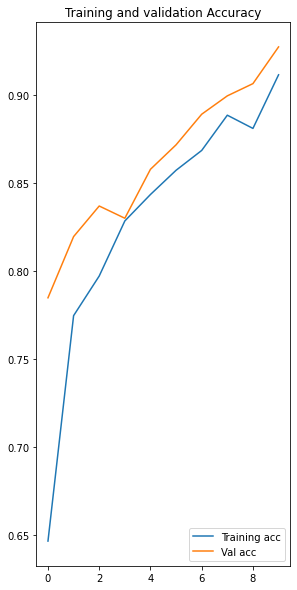

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training acc')
plt.plot(range(EPOCHS),val_acc,label='Val acc')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

First image to predict
Actual label:  yes
1/1 [==============================] - 1s 634ms/step
Predicted Label:  no


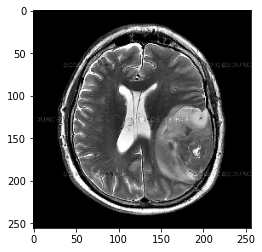

In [48]:
for img_batch, lab_batch in df.take(1):
    
    first_img = img_batch[7].numpy().astype('uint8')
    first_lab = lab_batch[7].numpy()
    
    print("First image to predict")
    plt.imshow(first_img)
    print("Actual label: ",class_names[first_lab])
    
    batch_pred = model.predict(img_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_pred[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


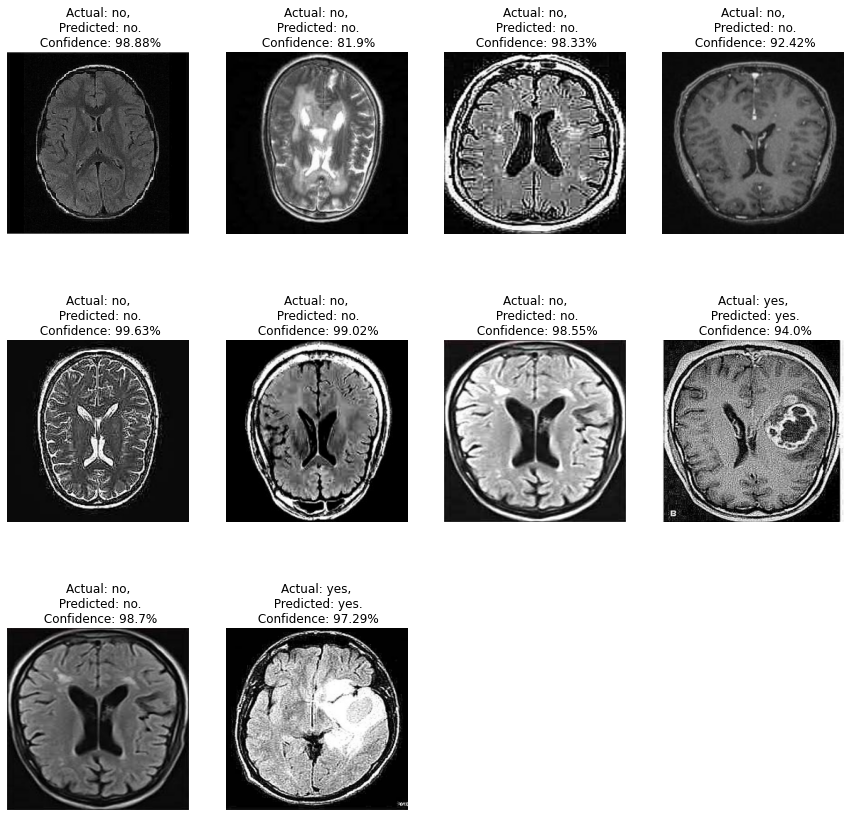

In [51]:
plt.figure(figsize=(15,15))
for images, labels in df.take(1):
    for i in range(10):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis('off')

In [52]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets


In [44]:
model_version=2
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/2\assets


INFO:tensorflow:Assets written to: ./models/2\assets
